In [1]:
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize
import pandas as pd
import seaborn as sns
from datetime import datetime  
from datetime import timedelta
# import datetime

In [2]:
def giveMeData(df, prov):
    df_temp=df[df["Province/State"]==prov]
    array = df_temp.to_numpy()
    return array[0][5:]
def giveMeDataCountry(df, prov):
    df_temp=df[df["Country/Region"]==prov]
    array = df_temp.to_numpy()
    return array[0][5:]

In [3]:
def CanadaData(data, prov):
    #Returns np array of cases in a province 
    df=data
    df_temp=df[df["prname"]==prov]
    cases=df_temp["numconf"].to_numpy()
    # dt_temp_dates=df_temp["date"].to_numpy()
    return cases

def CanadaDatatests(data, prov):
    #Returns np array of tests in a province 
    df_temp=data[data["prname"]==prov]
    tests=df_temp["numtested"].to_numpy()
    # dt_temp_dates=df_temp["date"].to_numpy()
    return tests
#     return np.nan_to_num(cases)

def CanadaDataDeaths(data, prov):
    df=data
    df_temp=df[df["prname"]==prov]
    cases=df_temp["numdeaths"].to_numpy()
    # dt_temp_dates=df_temp["date"].to_numpy()
    return cases
#     return np.nan_to_num(cases)



In [4]:
def func(x, L, k, M):
    return ( L /( 1 + np.exp(-1 * k * ( x - M ))))

In [5]:
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c
def Linefunc(x, m, b):
    return m*x+b


# AUTOMATIC

In [6]:
date_start= datetime.strptime("01/22/20", "%m/%d/%y")
end_date = date_start + timedelta(days=72)
print (end_date.date())

2020-04-03


## CDF Fitting and testing rates

In [110]:

def MakeMePrediction(where,maxfev):
    print("\n\n------------- "+where+ "-------------")
#     rawData="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
#     data = pd.read_csv(rawData)
    canada_Data="https://health-infobase.canada.ca/src/data/covidLive/covid19.csv"
    data = pd.read_csv(canada_Data)
    
    dataName=where
#     ont=givemedata(data,where)
    ont=CanadaData(data,where)
    
    totaltested=CanadaDatatests(data,dataName)
    
    
    deaths=CanadaDataDeaths(data,dataName)
    death_dates=np.arange(0,len(deaths)).astype(float)

    delta_testes=np.diff(totaltested)[:] #total tested
    d_tested_dates=np.arange(0,len(delta_testes))

    y_data = ont[0:].astype(float)
    x_data = np.arange(len(y_data)).astype(float)
    
    
    #Fit model
    params, params_covariance = optimize.curve_fit(func, x_data, y_data,
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)
    params1, params_covariance1 = optimize.curve_fit(func, x_data[0:-1], y_data[0:-1],
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)
    params3, params_covariance3 = optimize.curve_fit(func, x_data[0:-3], y_data[0:-3],
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)
    params5, params_covariance5 = optimize.curve_fit(func, x_data[0:-5], y_data[0:-5],
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)
    params10, params_covariance10 = optimize.curve_fit(func, x_data[0:-10], y_data[0:-10],
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)    
    param_ex, ex_cov = optimize.curve_fit(exponenial_func,x_data, y_data,
                                         p0=[100,0.01,-2000],maxfev=9000)

    #Out put raw data
    print ("dates: ",x_data)
    print ("cases: ",y_data)
    #Calculate sigma
    sigma = np.sqrt(np.diag(params_covariance))
    sigma1 = np.sqrt(np.diag(params_covariance1))
    print("-----")
    print("params PY: ",params)
    print("sigma PY: ", sigma)
    
#     #QA of data
#     plt.figure(figsize=(8, 6))
#     plt.title("Total number of cases for "+dataName+"!\n")
#     plt.scatter(x_data, y_data)
#     plt.plot(np.arange(len(y_data)),y_data)
#     plt.grid(alpha=0.2)
   

    #-------------------GAUSSIAN
    porjected_days=25
    
    delta_cases=np.diff(y_data)[:]
    delta_dates=np.arange(0,len(delta_cases)).astype(float)
    delta_x_future=np.arange(0,len(delta_cases)+porjected_days).astype(float)
    mean = sum(delta_dates * delta_cases) / sum(delta_cases)
    sigma_gfit = np.sqrt(sum(delta_cases * (delta_dates - mean)**2) / sum(delta_cases))
    popt,pcov   = curve_fit(Gauss, delta_dates, delta_cases, p0=[max(delta_cases), mean, sigma_gfit],maxfev=maxfev)
    popt1,pcov1 = curve_fit(Gauss, delta_dates[0:-1], delta_cases[0:-1], p0=[max(delta_cases[0:-1]), mean, sigma_gfit],maxfev=maxfev)
    popt2,pcov2 = curve_fit(Gauss, delta_dates[0:-2], delta_cases[0:-2], p0=[max(delta_cases[0:-2]), mean, sigma_gfit],maxfev=maxfev)
    popt3,pcov3 = curve_fit(Gauss, delta_dates[0:-3], delta_cases[0:-3], p0=[max(delta_cases[0:-3]), mean, sigma_gfit],maxfev=maxfev)
    popt4,pcov4 = curve_fit(Gauss, delta_dates[0:-4], delta_cases[0:-4], p0=[max(delta_cases[0:-4]), mean, sigma_gfit],maxfev=maxfev)
    popt5,pcov5 = curve_fit(Gauss, delta_dates[0:-5], delta_cases[0:-5], p0=[max(delta_cases[0:-5]), mean, sigma_gfit],maxfev=maxfev)
    popt6,pcov6 = curve_fit(Gauss, delta_dates[0:-6], delta_cases[0:-6], p0=[max(delta_cases[0:-6]), mean, sigma_gfit],maxfev=maxfev)
    popt7,pcov7 = curve_fit(Gauss, delta_dates[0:-7], delta_cases[0:-7], p0=[max(delta_cases[0:-7]), mean, sigma_gfit],maxfev=maxfev)
    popt8,pcov8 = curve_fit(Gauss, delta_dates[0:-8], delta_cases[0:-8], p0=[max(delta_cases[0:-8]), mean, sigma_gfit],maxfev=maxfev)
    popt9,pcov9 = curve_fit(Gauss, delta_dates[0:-9], delta_cases[0:-9], p0=[max(delta_cases[0:-9]), mean, sigma_gfit],maxfev=maxfev)

    x_pred_delta=np.arange(0,len(delta_cases)+porjected_days).astype(float)
    sigmaG = np.sqrt(np.diag(pcov))

    y_pred_plusG = Gauss(x_pred_delta, popt[0]+sigmaG[0], popt[1]+sigmaG[1], popt[2]+sigmaG[2])
    y_pred_minusG = Gauss(x_pred_delta, popt[0]-sigmaG[0], popt[1]-sigmaG[1], popt[2]-sigmaG[2])


    cases_in_14_days_higher = round(Gauss(delta_dates[-1]+14, popt[0]+sigmaG[0], popt[1]+sigmaG[1], popt[2]+sigmaG[2]))
    cases_in_14_days_lower = round( Gauss(delta_dates[-1]+14, popt[0]-sigmaG[0], popt[1]-sigmaG[1], popt[2]-sigmaG[2]))
    
    plt.figure(figsize=(12, 8))
    plt.title("new number of cases by day for "+where+"!\n"+"Estimated daily cases in 14 days: ~["+
              str(cases_in_14_days_higher)+", "+str(cases_in_14_days_lower)+"] (1σ)")
    plt.xlabel("Days from Day0(see note at top)")
    plt.ylabel("Cases")
    plt.scatter(delta_dates, delta_cases, alpha=0.9)
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt[0], popt[1], popt[2]),
                 label='Fitted function gauss', color='green')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt1[0], popt1[1], popt1[2]), alpha=0.4,
                 label='n-1')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt2[0], popt2[1], popt2[2]), alpha=0.4,
                 label='n-2')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt3[0], popt3[1], popt3[2]), alpha=0.4,
                 label='n-3')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt4[0], popt4[1], popt4[2]), alpha=0.4,
                 label='n-4')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt5[0], popt5[1], popt5[2]), alpha=0.4,
                 label='n-5')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt6[0], popt6[1], popt6[2]), alpha=0.4,
                 label='n-6')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt7[0], popt7[1], popt7[2]), alpha=0.4,
                 label='n-7')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt8[0], popt8[1], popt8[2]), alpha=0.4,
                 label='n-8')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt9[0], popt9[1], popt9[2]), alpha=0.4,
                 label='n-9')
    plt.fill_between(x_pred_delta, y_pred_minusG,y_pred_plusG, alpha=0.3,label='1 Sigma on Signal')

    plt.grid(alpha=0.2)
    plt.vlines(x=delta_dates[-1]+14,colors='red',ymin=-10,ymax=np.max(delta_cases)+50, 
               label='14 days from last data point', alpha=0.75,linestyles="dashed")     # 2 weeks from now
    plt.legend(loc='best')
    plt.show()


    #-------------------MODEL!!!
    plt.figure(figsize=(12, 8))
    plt.xlabel("Days from Day0(see note at top)")
    plt.ylabel("Cases")
    plt.scatter(x_data, y_data, label='Data')
    plt.scatter(death_dates,deaths,label='Deaths',color='red')

    projected_days_m=30
    x_pred=np.arange(0,len(y_data)+projected_days_m).astype(float)
    x_future=np.arange(0,len(y_data)+projected_days_m).astype(float)
    days=0
    daysLP=days


    print("----\nPY:")
    print("sigma+: "+ str(round(func(len(y_data)+days, params[0]+sigma[0], params[1]+sigma[1], params[2]-sigma[2]))))
    print("n+1: "+ str(round(func(len(y_data)+days, params[0], params[1], params[2]))))
    print("Sigma-: "+ str(round(func(len(y_data)+days, params[0]-sigma[0], params[1]-sigma[1], params[2]+sigma[2]))))
    print("----\n")
    print("params PY: ",params)
    print("PY sigma: ",sigma)
    print("max cases: ", round(params[0]))
    print("infection point: ", round(params[2]))
    date_start= datetime.strptime("01/31/20", "%m/%d/%y")
    infectionpoint = date_start + timedelta(days=round(params[2]))
    print ("infection point date: ",infectionpoint.date())


    y_pred_plus = func(x_future, params[0]+sigma[0], params[1]+sigma[1], params[2]-sigma[2])
    y_pred_minus = func(x_future, params[0]-sigma[0], params[1]-sigma[1], params[2]+sigma[2])
    plt.fill_between(x_future, y_pred_minus,y_pred_plus, alpha=0.3,label='1 Sigma on Signal')
    
    y_pred_plus1 = func(x_future, params1[0]+sigma1[0], params1[1]+sigma1[1], params1[2]-sigma1[2])
    y_pred_minus1 = func(x_future, params1[0]-sigma1[0], params1[1]-sigma1[1], params1[2]+sigma1[2])
    plt.fill_between(x_future, y_pred_minus1,y_pred_plus1, alpha=0.1,label='1 Sigma on n-1',color="c3")

    plt.plot(x_pred, func(x_pred, params[0], params[1], params[2]),
             label='Fitted function Py')
    plt.plot(x_pred, func(x_pred, params1[0], params1[1], params1[2]), alpha=0.7,
             label='1 Day ago')
    plt.plot(x_pred, func(x_pred, params3[0], params3[1], params3[2]), alpha=0.7,
             label='3 Days ago')
    plt.plot(x_pred, func(x_pred, params5[0], params5[1], params5[2]), alpha=0.7,
             label='5 Days ago')
    plt.plot(x_pred, func(x_pred, params10[0], params10[1], params10[2]), alpha=0.7,
             label='10 Days ago')
#     plt.plot(x_pred, exponenial_func(x_pred, param_ex[0], param_ex[1], param_ex[2]), alpha=0.7,
#              label='exponenial fit')
    
    plt.vlines(x=x_data[-1]+14,colors='red',ymin=-10,ymax=np.max(y_pred_plus)+100, 
               label='14 days from last data point', alpha=0.75,linestyles="dashed")     # 2 weeks from now
    plt.legend(loc='best')
    plt.tick_params(labelright=True)
    plt.grid(alpha=0.2)
#     plt.xlim(-10, 80)
    # plt.semilogy(basey=1)
#     plt.yscale('log')
    plt.title("Total number of cases for "+dataName+"!\n max cases: ~" + str(round(params[0])))# +"\n infection point date: ~"+str(infectionpoint.date()) )
    plt.show()
    
    
    #-------------------tests for cases-------------------

    x_pred_delta_tests=np.arange(0,len(delta_cases)+5).astype(float)

    tested_dates=np.arange(0,totaltested.size)
    valid = ~(np.isnan(tested_dates) | np.isnan(totaltested))
    popt_line_t, pcov_line_t = curve_fit(Linefunc, tested_dates[valid][0:-1], totaltested[valid][0:-1], p0=[ 1000, 10],maxfev=9000)
    popt_line_t_L7, pcov_line_t_L7 = curve_fit(Linefunc, tested_dates[valid][-8:-1], totaltested[valid][-8:-1], p0=[ 1000, 10],maxfev=9000)

    plt.figure(figsize=(12,8))
    plt.xlabel("Days from Day0(see note at top)")
    plt.ylabel("Tests")
    plt.title("Total test to day in "+dataName+"!\n"+"Rate: "+str(round(popt_line_t[0]))+" tests/day (cumulative)\n"
             +"Rate: "+str(round(popt_line_t_L7[0]))+" tests/day (last 7 days)\n"+
             "Precent of positive cases pre test:"+ str(round ((y_data[-1]/totaltested[-1])*100,3)) +"%" )
    plt.scatter(np.arange(0,totaltested.size),totaltested, label='data')
    plt.plot(x_pred_delta_tests, Linefunc(x_pred_delta_tests, popt_line_t[0], popt_line_t[1]), color="green",alpha=0.9, label='ploy1 fit')
    plt.plot(x_pred_delta_tests, Linefunc(x_pred_delta_tests, popt_line_t_L7[0], popt_line_t_L7[1]), alpha=0.6, label='last 7 days ploy1 fit ')
    plt.legend(loc='best')
    plt.grid(alpha=0.2,which='both')
    plt.show()
    #--
    valid = ~(np.isnan(d_tested_dates) | np.isnan(delta_testes))
    popt_line, pcov_line = curve_fit(Linefunc, d_tested_dates[valid][0:-1], delta_testes[valid][0:-1], p0=[ 1000, 10],maxfev=9000)
    popt_line_L7, pcov_line_L7 = curve_fit(Linefunc, d_tested_dates[valid][-8:-1], delta_testes[valid][-8:-1], p0=[ 1000, 10],maxfev=9000)

    plt.figure(figsize=(12, 8))
    plt.xlabel("Days from Day0(see note at top)")
    plt.ylabel("Tests")
    plt.title("Tests by day for "+dataName+"!\n"+"Rate: "+str(round(popt_line[0]))+" additional tests/day(cumulative)\n"
             +"Rate: "+str(round(popt_line_L7[0]))+" tests/day (last 7 days)\n"+
             "Precent of positive cases pre test:"+ str(round ((y_data[-1]/totaltested[-1])*100,3)) +"%" )
    plt.scatter( d_tested_dates,delta_testes, label='tests by day')
    plt.plot(x_pred_delta_tests, Linefunc(x_pred_delta_tests, popt_line[0], popt_line[1]), color="green",alpha=0.9, label='ploy1 fit')
    plt.plot(x_pred_delta_tests, Linefunc(x_pred_delta_tests, popt_line_L7[0], popt_line_L7[1]),alpha=0.6, label='last 7 days ploy1 fit ')
    plt.legend(loc='best')
    plt.grid(alpha=0.2,which='both')
    plt.show()
    
    print("Precent of positive cases pre test:", str(round ((y_data[-1]/totaltested[-1])*100,3)) ,"%" )

    

### The Cruve for everywhere

In [111]:
def TheCruve(AllofCanada,AllofCanadaAbv,maxfev):

    where="Ontario"

    canada_Data="https://health-infobase.canada.ca/src/data/covidLive/covid19.csv"
    data = pd.read_csv(canada_Data)

    plt.figure(figsize=(12, 8))
    plt.title("Daily cases by province\n AKA \"The Curve\"")
    plt.xlabel("Day from Day 0 of each data set (see note to the top)")
    plt.ylabel("Cases")
    porjected_days=55

    for i,where in enumerate(AllofCanada):
        ont=CanadaData(data,where)
        y_data = ont[0:].astype(float)
        x_data = np.arange(len(y_data)).astype(float)

        delta_cases=np.diff(y_data)[:]
        delta_dates=np.arange(0,len(delta_cases)).astype(float)
        delta_x_future=np.arange(0,len(delta_cases)+porjected_days).astype(float)
        mean = sum(delta_dates * delta_cases) / sum(delta_cases)
        sigma_gfit = np.sqrt(sum(delta_cases * (delta_dates - mean)**2) / sum(delta_cases))
        popt,pcov   = curve_fit(Gauss, delta_dates, delta_cases, p0=[max(delta_cases), mean, sigma_gfit],maxfev=maxfev)

        plt.scatter(delta_dates, delta_cases, alpha=0.3,
                    label='Data for '+AllofCanadaAbv[i])
        plt.plot(delta_x_future, Gauss(delta_x_future, popt[0], popt[1], popt[2]),
                 label='Gaus. '+AllofCanadaAbv[i])

#     plt.yscale('log')

#     plt.vlines(x=delta_dates[-1]+14,colors='red',ymin=0,ymax=np.max(delta_cases))
#     plt.show()
    plt.vlines(x=(len(CanadaData(data,'Canada')))+14,colors='red',ymin=-10,ymax=np.max(np.diff(CanadaData(data,'Canada'))[:])+50, 
               label='14 days from last data point', alpha=0.75, linestyles="dashed")     # 2 weeks from now
    plt.legend(loc='best')
    plt.show()


    plt.figure(figsize=(12, 8))
    plt.title("Normalized Daily cases by province\n AKA \"The Curve\"")
    plt.xlabel("Day from Day 0 of each data set (see note to the top)")
    plt.ylabel("Normalized Cases")

    for i,where in enumerate(AllofCanada):
        ont=CanadaData(data,where)
        y_data = ont[0:].astype(float)
        y_data = y_data / np.sqrt(np.sum(y_data**2))
        x_data = np.arange(len(y_data)).astype(float)

        delta_cases=np.diff(y_data)[:]
        delta_dates=np.arange(0,len(delta_cases)).astype(float)
        delta_x_future=np.arange(0,len(delta_cases)+porjected_days).astype(float)
        mean = sum(delta_dates * delta_cases) / sum(delta_cases)
        sigma_gfit = np.sqrt(sum(delta_cases * (delta_dates - mean)**2) / sum(delta_cases))
        popt,pcov   = curve_fit(Gauss, delta_dates, delta_cases, p0=[max(delta_cases), mean, sigma_gfit],maxfev=maxfev)

    #     plt.scatter(delta_dates, delta_cases, alpha=0.1,
    #                 label='Data for '+AllofCanadaAb[i])
        if where=="Canada":
            plt.plot(delta_x_future, Gauss(delta_x_future, popt[0], popt[1], popt[2]),
                     label='Gaus. '+AllofCanadaAbv[i],linewidth=4)        
        else:
            plt.plot(delta_x_future, Gauss(delta_x_future, popt[0], popt[1], popt[2]),
                     label='Gaus. '+AllofCanadaAbv[i],alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    print("The plot above shows total cases normalized to 1 for each province \n\n\n")
    
        

### Main calls

Last updated: 2020-05-02 22:40:58

    Waqar Muhammad - mwaqar@snolab.ca
    
    NOTE:
    All of the following was data is from Health Canada. 
    The CDF fit is a logicitsts curve fit. 
    The PDF fit is a simple gaussian fit. 
    Day 0 is:
    -> 31-01-2020 for Canada 
    -> 08-03-2020 for AB
    -> 31-01-2020 for BC
    -> 11-03-2020 for MN
    -> 11-03-2020 for NB
    -> 11-03-2020 for NL
    -> 11-03-2020 for NS
    -> 31-01-2020 for ON
    -> 11-03-2020 for PEI
    -> 01-03-2020 for QC
    -> 11-03-2020 for SW


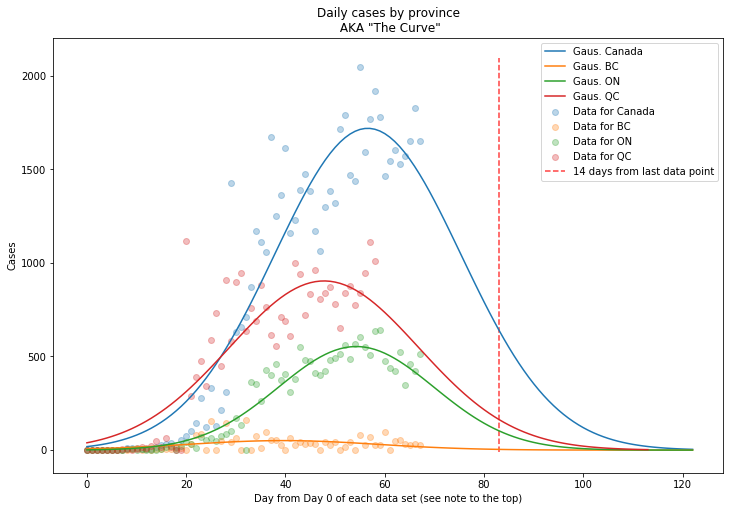

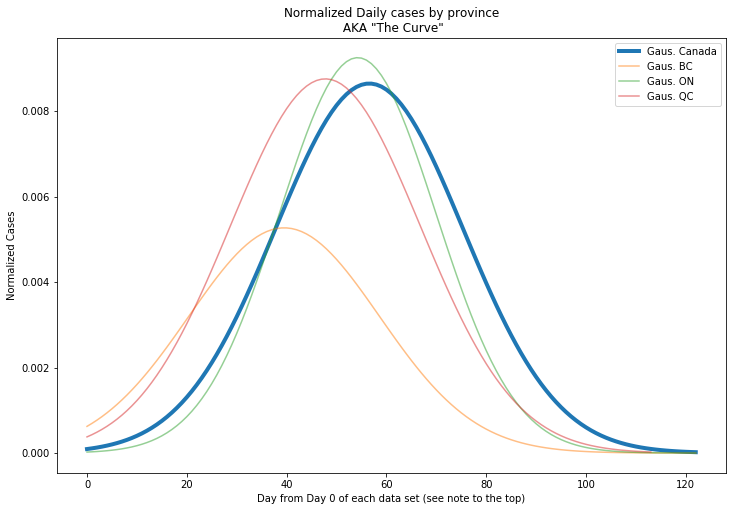

The plot above shows total cases normalized to 1 for each province 





------------- Canada-------------
dates:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68.]
cases:  [4.0000e+00 7.0000e+00 8.0000e+00 9.0000e+00 1.0000e+01 1.1000e+01
 1.2000e+01 1.3000e+01 1.5000e+01 2.4000e+01 3.3000e+01 4.5000e+01
 5.1000e+01 5.7000e+01 6.2000e+01 7.7000e+01 1.0300e+02 1.3800e+02
 1.7600e+02 1.9300e+02 2.4900e+02 3.2400e+02 4.2400e+02 5.6900e+02
 8.4600e+02 9.7100e+02 1.3020e+03 1.4300e+03 1.6460e+03 1.9590e+03
 3.3850e+03 4.0180e+03 4.6750e+03 5.3860e+03 6.2550e+03 7.4240e+03
 8.5360e+03 9.5950e+03 1.1268e+04 1.2519e+04 1.3882e+04 1.5496e+04
 1.6653e+04 1.7883e+04 1.9274e+04 2.0748e+04 2.2133e+04 2.3301e+04
 2.4365e+04 2.5663e+04 2.7046e+04 2.8364e+04 3.0081e+04 3.18

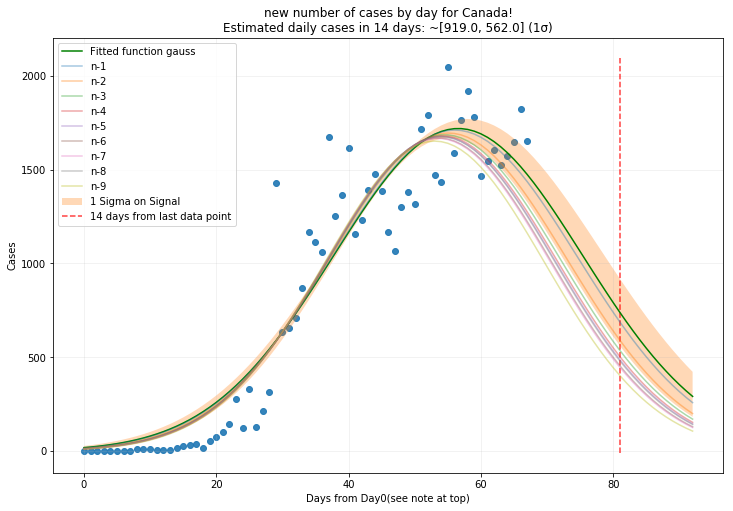

----
PY:
sigma+: 57708.0
n+1: 55399.0
Sigma-: 53087.0
----

params PY:  [6.42301799e+04 1.12977530e-01 5.27463641e+01]
PY sigma:  [1.61998728e+03 3.43243972e-03 5.69080551e-01]
max cases:  64230.0
infection point:  53.0
infection point date:  2020-03-24


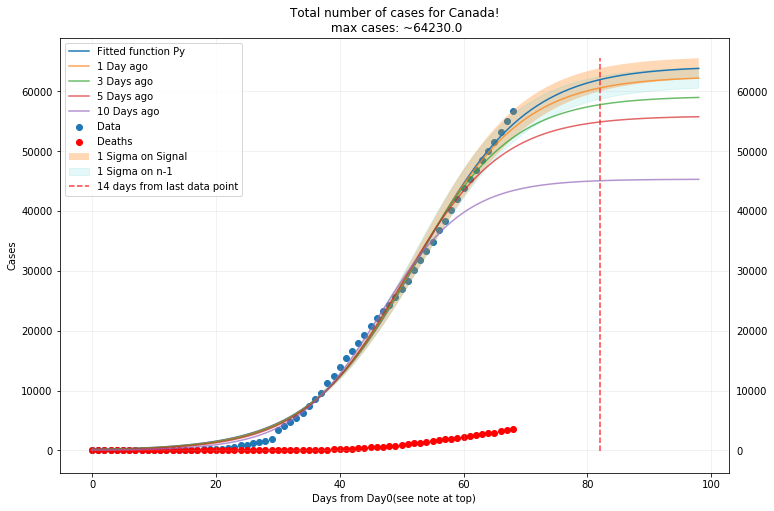

ValueError: '\%' is not a valid location

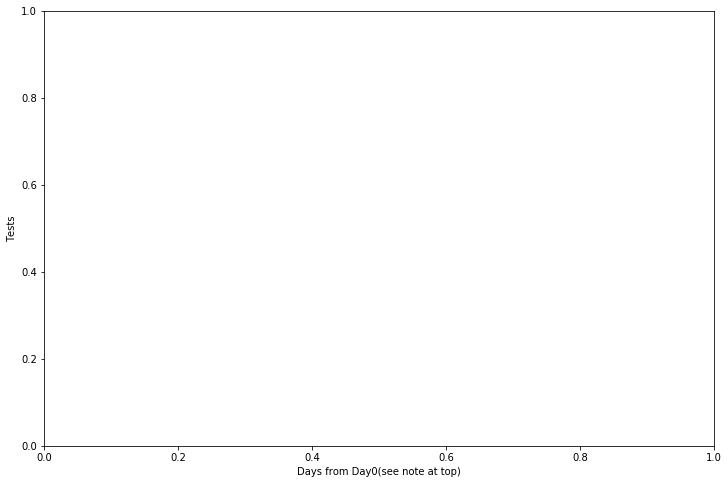

In [112]:
%matplotlib inline
# %time
print ("Last updated: "+datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


note="""
    Waqar Muhammad - mwaqar@snolab.ca
    
    NOTE:
    All of the following was data is from Health Canada. 
    The CDF fit is a logicitsts curve fit. 
    The PDF fit is a simple gaussian fit. 
    Day 0 is:
    -> 31-01-2020 for Canada 
    -> 08-03-2020 for AB
    -> 31-01-2020 for BC
    -> 11-03-2020 for MN
    -> 11-03-2020 for NB
    -> 11-03-2020 for NL
    -> 11-03-2020 for NS
    -> 31-01-2020 for ON
    -> 11-03-2020 for PEI
    -> 01-03-2020 for QC
    -> 11-03-2020 for SW"""
print(note)


AllofCanada=[ "Canada","British Columbia", "Ontario", "Quebec"]
AllofCanadaAbv=["Canada","BC","ON","QC"]

# AllofCanada=["Canada","Alberta","British Columbia", "Ontario", "Quebec"]
# AllofCanadaAbv=["Canada","AB","BC","ON","QC"]

# AllofCanada=["Canada","Alberta","British Columbia", "Manitoba", "New Brunswick", 
#               "Newfoundland and Labrador", "Nova Scotia", "Ontario", "Prince Edward Island", "Quebec", "Saskatchewan"]
# AllofCanadaAbv=["Canada","AB","BC", "MN", "NB", 
#               "NL", "NS", "ON", "PEI", "QC", "SW"]

AllofCanadaNoAB=["Canada","British Columbia", "Manitoba", "New Brunswick", 
              "Newfoundland and Labrador", "Nova Scotia", "Ontario", "Prince Edward Island", "Quebec", "Saskatchewan"]
AllofCanadaAbvNoAB=["Canada","BC", "MN", "NB", 
              "NL", "NS", "ON", "PEI", "QC", "SW"]

TheCruve(AllofCanada,AllofCanadaAbv,519000)

for i in AllofCanada:
    MakeMePrediction(i,519000)


    
    
    
    
    
    
    
    
